## Digit Image Annotation Dataset Generator

This notebook will identify misclassified digits in raw images and copy those raw images to a training dataset directory for manual annotation.

In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import celldom
import matplotlib.pyplot as plt
import plotnine as pn
from celldom.config import experiment_config
from celldom.core import cytometry
from celldom.execute import processing
from celldom.extract import ALL_IMAGES

#### Select Images to Re-process

In [2]:
# G1 Results
OUTPUT_DIR = '20181003-G1-full'
EXP_CONFIG = 'exp-20180217-G1-K562-control-01'
DATA_DIR = osp.join(celldom.get_data_dir(), 'output', OUTPUT_DIR)
DATA_DIR

'/lab/data/celldom/output/20181003-G1-full'

In [ ]:
# G2 Results
# OUTPUT_DIR = ''
# EXP_CONFIG = 'exp-20180531-G2-MOLM13-quizartinib-poc-01'
# DATA_DIR = osp.join(celldom.get_data_dir(), 'output', OUTPUT_DIR)
# DATA_DIR

In [3]:
# G3 Results
# OUTPUT_DIR = '20180911-G3-yl'
# EXP_CONFIG = 'exp-20180614-G3-K562-imatinib-poc-01'
# DATA_DIR = osp.join(celldom.get_data_dir(), 'output', OUTPUT_DIR)
# DATA_DIR

In [3]:
config = experiment_config.get_exp_config_by_name(EXP_CONFIG)
store = cytometry.get_readonly_datastore(DATA_DIR)

In [4]:
df = store.get('apartment')
image_file_map = store.get('acquisition').set_index('acq_id')['raw_image_path']
df['raw_image_path'] = df['acq_id'].map(image_file_map)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5825 entries, 0 to 6
Data columns (total 35 columns):
acq_apartment             5825 non-null object
acq_cell_line             5825 non-null object
acq_datetime              5825 non-null datetime64[ns]
acq_hours                 5825 non-null object
acq_id                    5825 non-null object
acq_processed_at          5825 non-null datetime64[ns]
acq_street                5825 non-null object
apt_id                    5825 non-null int64
apt_image_height          5825 non-null int64
apt_image_width           5825 non-null int64
apt_num                   5825 non-null object
apt_num_digit_scores      5825 non-null object
cell_area_mean            3643 non-null float64
cell_area_p10             3643 non-null float64
cell_area_p50             3643 non-null float64
cell_area_p90             3643 non-null float64
cell_area_std             2182 non-null float64
cell_count                5825 non-null int64
cell_eccentricity_mean    3643 no

In [5]:
chip_config = config.get_chip_config()
dfe = df[ \
    ~df['apt_num'].astype(int).between(*chip_config['apt_num_range']) | \
    ~df['st_num'].astype(int).between(*chip_config['st_num_range']) \
]

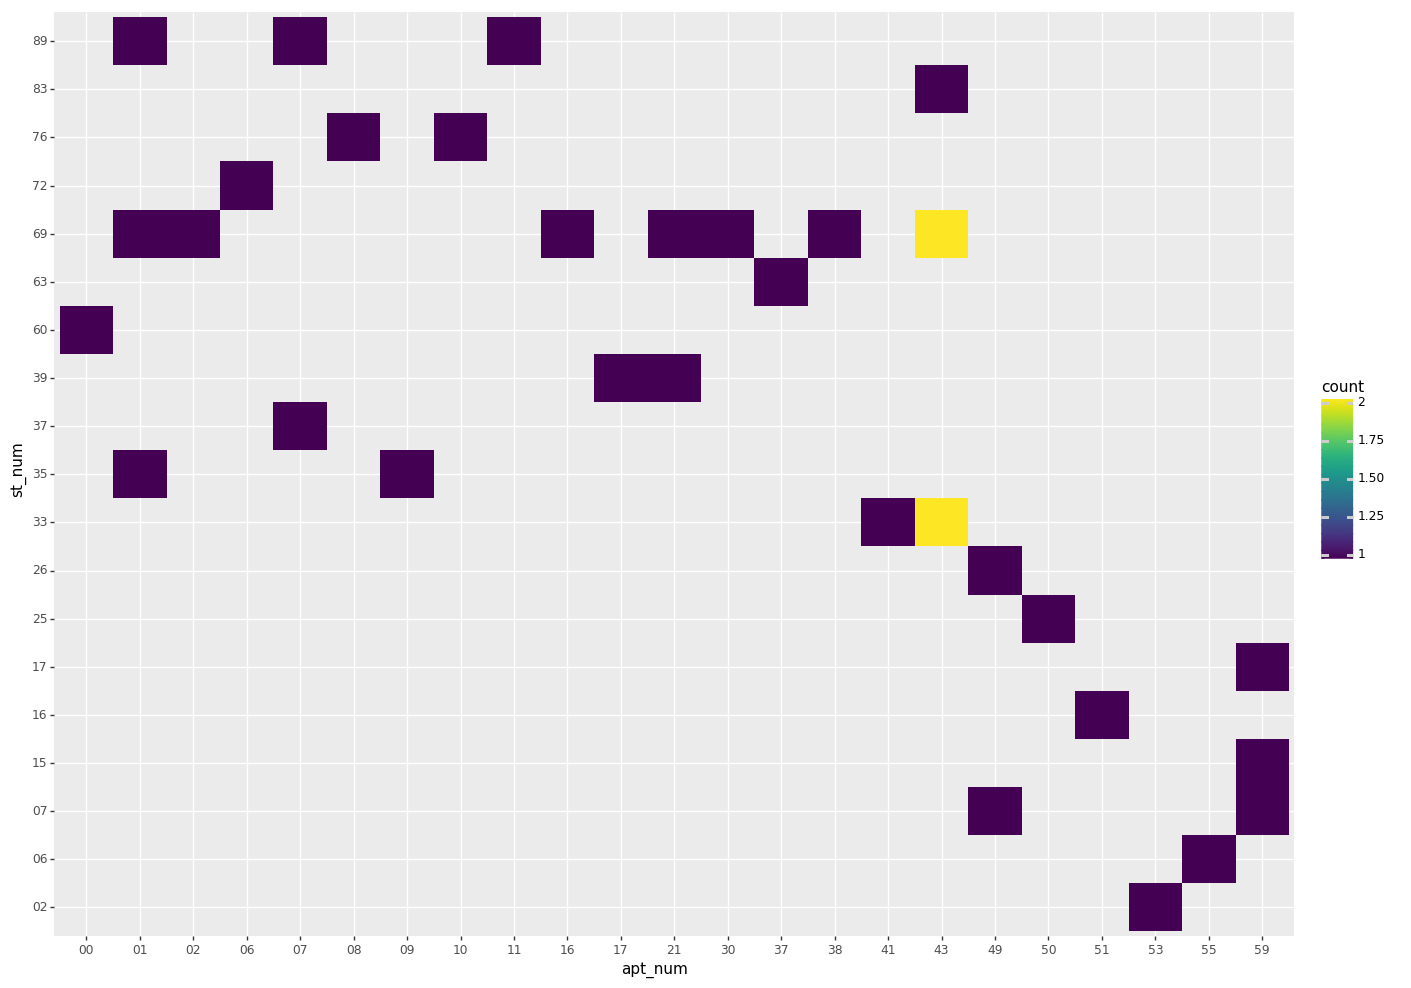

<ggplot: (8766615459967)>

In [6]:
(
    pn.ggplot(
        dfe.groupby(['apt_num', 'st_num']).size().rename('count').reset_index(), 
        pn.aes(x='apt_num', y='st_num', fill='count')
    ) +
    pn.geom_tile() + 
    pn.theme(figure_size=(16,12))
)

In [7]:
dfe.iloc[0]

acq_apartment                                                           016
acq_cell_line                                                          K562
acq_datetime                                            2018-02-17 00:00:00
acq_hours                                                                 0
acq_id                                     2b9ec1174cefa2f120890eb402d76dee
acq_processed_at                                        2018-10-04 10:43:57
acq_street                                                              002
apt_id                                                                    6
apt_image_height                                                        193
apt_image_width                                                         185
apt_num                                                                  02
apt_num_digit_scores                                            1.000,1.000
cell_area_mean                                                          NaN
cell_area_p1

In [8]:
dfe.iloc[0]['raw_image_path']

'/lab/data/celldom/dataset/dataset06/2018.02.17 G1 35 K562 Test 2 0 hr 201802170000/BF_16X_St_002_Apt_016_F_000.tif'

#### Reprocess Selected Images

In [9]:
# image_files = [
#     f.replace('/lab/data/celldom/JeffsData', '/lab/data/celldom/dataset/dataset05')
#     for f in dfe['raw_image_path'].unique()
# ]
image_files = list(dfe['raw_image_path'].unique())
len(image_files)

31

In [10]:
sample_files = pd.Series(image_files).sample(n=min(len(image_files), 500), random_state=celldom.seed).tolist()
len(sample_files)

31

In [11]:
output_dir = '/tmp/test'
if osp.exists(output_dir):
    !rm -rf /tmp/test/*

In [12]:
%%time
res = processing.run_cytometer(
    config, output_dir, sample_files, 
    max_failures=10000, dpf=ALL_IMAGES, 
    return_results=True, save_results=False
)

Using TensorFlow backend.
100%|██████████| 31/31 [01:22<00:00,  2.68s/it]

CPU times: user 2min 10s, sys: 2min 7s, total: 4min 18s
Wall time: 1min 44s


#### Extract Digit Images for OOB Addresses

In [13]:
import tqdm
apt_range, st_range, chip_name = chip_config['apt_num_range'], chip_config['st_num_range'], chip_config['name']


def get_digit_records(acq_id, apt_id, imgs, typ, digits):
    assert isinstance(digits, str)
    assert len(imgs) == len(digits)
    res = []
    for i in range(len(imgs)):
        filename = '{}-{}-{}-{}-{}-{}.png'.format(chip_name, acq_id, apt_id, typ, i, digits[i])
        res.append(dict(
            acq_id=acq_id, apt_id=apt_id, type=typ, filename=filename, 
            label=digits[i], image=imgs[i]
        ))
    return res
            
def extract_bad_digits(res, extra_sample_rate=None):
    np.random.seed(celldom.seed)
    df_digit = []
    for row in tqdm.tqdm(res):
        df = row[1] # Get apartment data frame
        valid = df['apt_num'].astype(int).between(*chip_config['apt_num_range']) & \
            df['st_num'].astype(int).between(*chip_config['st_num_range'])

        # Loop through single rows for each apartment
        for i, (_, r) in enumerate(df.iterrows()):
            # Skip if the row is valid (or not randomly selected to increase training set sizes)
            if valid.iloc[i]:
                if extra_sample_rate is not None and np.random.rand(1)[0] > extra_sample_rate:
                    continue
            acq_id, apt_id = r['acq_id'], r['apt_id']
            apt_num, st_num = r['apt_num'], r['st_num']

            # Save all apartment and street digit images
            df_digit.extend(get_digit_records(acq_id, apt_id, r['apt_num_digit_images'], 'apt', apt_num))
            df_digit.extend(get_digit_records(acq_id, apt_id, r['st_num_digit_images'], 'st', st_num))
    return pd.DataFrame(df_digit)


#df_digit = extract_bad_digits(res)
#df_digit = extract_bad_digits(res, extra_sample_rate=.05)
df_digit = extract_bad_digits(res, extra_sample_rate=1.)

100%|██████████| 31/31 [00:00<00:00, 119.78it/s]


In [14]:
len(df_digit)

1308

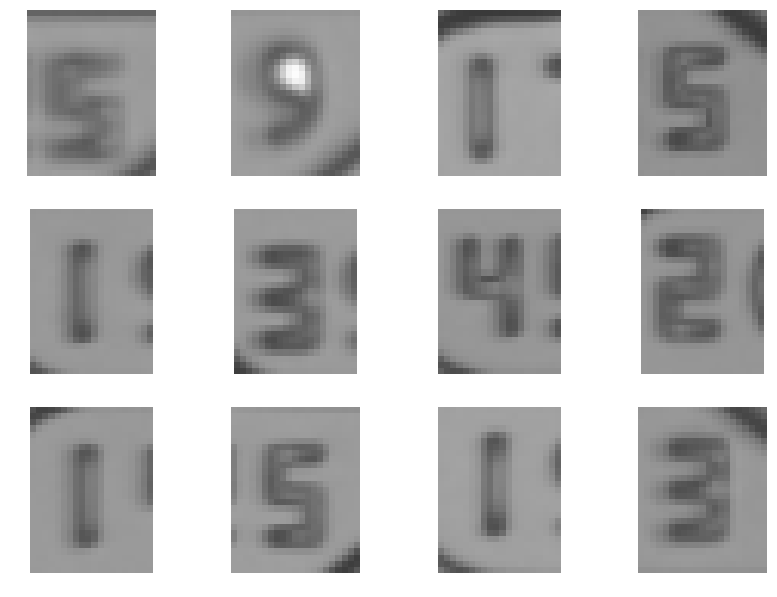

In [27]:
from cvutils import visualize
visualize.display_images(df_digit['image'].sample(n=12).tolist())

In [28]:
df_digit.groupby('type').size()

type
apt    654
st     654
dtype: int64

In [29]:
df_digit.groupby('label').size()

label
0    163
1    348
2    163
3    123
4    119
5     47
6     78
7     94
8     79
9     94
dtype: int64

In [30]:
df_digit.groupby(['type', 'label']).size()

type  label
apt   0        114
      1        154
      2         58
      3         79
      4         95
      5         23
      6          8
      7         31
      8         40
      9         52
st    0         49
      1        194
      2        105
      3         44
      4         24
      5         24
      6         70
      7         63
      8         39
      9         42
dtype: int64

In [31]:
df_digit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 6 columns):
acq_id      1308 non-null object
apt_id      1308 non-null int64
filename    1308 non-null object
image       1308 non-null object
label       1308 non-null object
type        1308 non-null object
dtypes: int64(1), object(5)
memory usage: 61.4+ KB


### Export Images for Annotation

In [32]:
#RESULT_DIR = osp.join(celldom.get_dataset_dir(), 'training', 'digit', 'r0.6', 'manual', 'single')
#RESULT_DIR = osp.join(celldom.get_dataset_dir(), 'training', 'digit', 'r0.6', 'manual', 'single', 'pt3')
RESULT_DIR = osp.join(celldom.get_dataset_dir(), 'training', 'digit', 'r0.6', 'manual', 'single', 'pt4')
RESULT_DIR

'/lab/data/celldom/dataset/training/digit/r0.6/manual/single/pt4'

In [33]:
if not osp.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

In [34]:
df_digit['filename'].head(3).values

array(['G01-6024d7a4b3b581321c7726eaa897a571-7-apt-0-1.png',
       'G01-6024d7a4b3b581321c7726eaa897a571-7-apt-1-7.png',
       'G01-6024d7a4b3b581321c7726eaa897a571-7-st-0-1.png'], dtype=object)

In [35]:
from skimage import io as sk_io

for i, r in tqdm.tqdm(df_digit.iterrows()):
    path = osp.join(RESULT_DIR, r['filename'])
    img = r['image']
    sk_io.imsave(path, img)

1308it [00:01, 854.83it/s]
